In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
regressor_performance_df = pd.read_excel("regressor_performance.xlsx")
labelranking_performance_df = pd.read_excel("rpc_performance.xlsx")

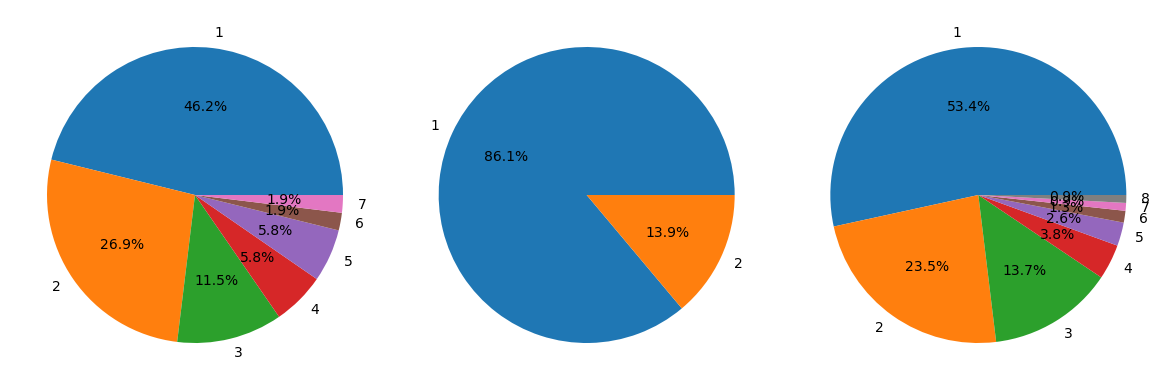

In [3]:
fig, ax = plt.subplots(ncols=3, tight_layout=True, figsize=(12,4))

for i, oos in enumerate(["halide", "additive", "both"]) :
    ranks = regressor_performance_df[
        regressor_performance_df["OOS"] == oos
    ]["Top Rank"]
    sizes = [len(np.where(ranks == x)[0]) for x in sorted(ranks.unique())]
    labels = sorted(ranks.unique())
    ax[i].pie(sizes, labels=labels, autopct='%1.1f%%')
    # ax[i].set_title(f"{oos} out-of-training-sample")

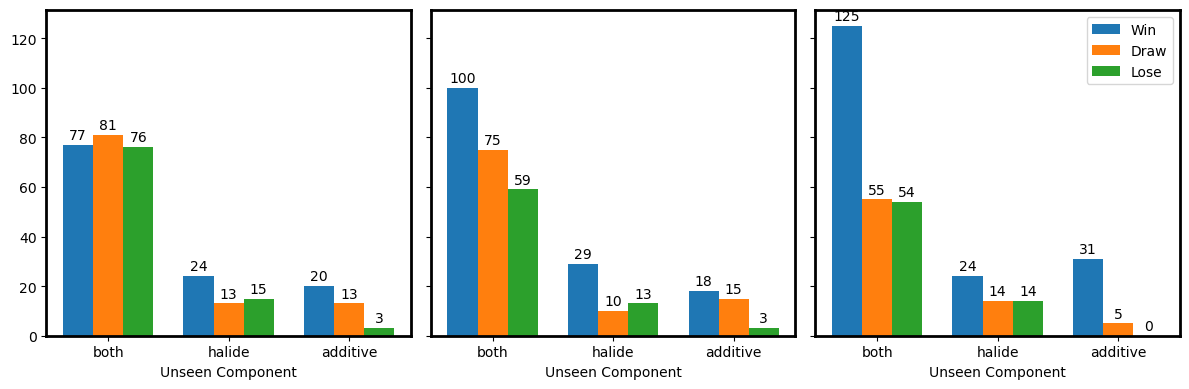

In [4]:
oos_choices = ["both","halide","additive"]

x = np.arange(3)

fig, ax = plt.subplots(ncols=3, figsize=(12,4), tight_layout=True, sharey=True)
for j, model in enumerate(["Pairwise", "LBRF", "LRT"]):
    regressor_w_d_l = np.zeros((3,3))
    for i, row in labelranking_performance_df[labelranking_performance_df["Model"]==model].iterrows():
        halide = row["Test halide"]
        additive = row["Test additive"]
        oos = row["OOS"]

        rpc_top_rank = row["Top Rank"]
        regressor_top_rank = regressor_performance_df[
            (regressor_performance_df["Test halide"] == halide) &\
            (regressor_performance_df["Test additive"] == additive) &\
            (regressor_performance_df["OOS"] == oos)
        ]["Top Rank"].values
        assert len(regressor_top_rank) ==1
        regressor_top_rank = regressor_top_rank[0]
        # print(rpc_top_rank, regressor_top_rank)

        if regressor_top_rank < rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 0] += 1
        elif regressor_top_rank == rpc_top_rank :
            regressor_w_d_l[oos_choices.index(oos), 1] += 1
        else : 
            regressor_w_d_l[oos_choices.index(oos), 2] += 1

    width=0.25
    multiplier = 0
    for oos_ind, measure in enumerate(regressor_w_d_l) :
        offset = width * multiplier
        rects = ax[j].bar(x + offset, regressor_w_d_l[:, oos_ind].flatten(), width)
        ax[j].bar_label(rects, padding=2)
        multiplier += 1
    ax[j].set_xticks(x+width, oos_choices)
    ax[j].set_xlabel("Unseen Component")
    if j == 2 :
        ax[j].legend(["Win", "Draw", "Lose"], loc="upper right")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(2)